<a href="https://colab.research.google.com/github/sgr1118/Do-it-Deep-Learning/blob/main/8ch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# 합성곱 신경망 구현
import tensorflow as tf
import numpy as np

class ConvolutionNetwork:

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels  # 합성곱의 커널 개수
    self.kernel_size = 3        # 커널 크기
    self.optimizer = None       # 옵티마이저
    self.conv_w = None          # 합성곱 층의 가중치
    self.conv_b = None          # 합성곱 층의 절편
    self.units = units          # 은닉층의 뉴런 개수
    self.batch_size = batch_size  # 배치 크기
    self.w1 = None              # 은닉층의 가중치
    self.b1 = None              # 은닉층의 절편
    self.w2 = None              # 출력층의 가중치
    self.b2 = None              # 출력층의 절편
    self.a1 = None              # 은닉층의 활성화 출력
    self.losses = []            # 훈련 손실
    self.val_losses = []        # 검증 손실
    self.lr = learning_rate     # 학습률

  def forpass(self, x):
    # 3*3 합성곱 연산 수행
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b

    # 렐루 함수 적용
    r_out = tf.nn.relu(c_out)

    # 풀릴 적용하고 완전 연결층 수정하기
    # 2*2 최대 풀링을 적용
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')

    # 첫번째 배치 차원을 제외하고 출력을 일렬로 펼침
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1 # 첫 번째 층의 선형식을 계산
    a1 = tf.nn.relu(z1) # 활성화 함수 적용
    z2 = tf.matmul(a1, self.w2) + self.b2 # 두 번째 층의 선형식을 계산
    return z2

    # init_weights() 메서드 수정하기
  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    n_features = 14 * 14 * self.n_kernels
    self.w1 = tf.Variable(g((n_features, self.units))) # (특성 개수, 은닉층의 크기)
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float) # 은닉층의 크기
    self.w2 = tf.Variable(g((self.units, n_classes))) # (은닉층의 크기, 클래스 개수)
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float) # 클래스 개수

  # 옵티마이저 객체를 만들어 가중치 초기화
  # fit() 메서드 수정하기
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1]) # 은닉층과 출력층의 가중치를 초기화
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    # epochs만큼 반복
    for i in range(epochs):
      print('에포크', i, end=' ')
      # 제너레이터 함수에서 반환한 미니 배치를 순환
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='')
        self.training(x_batch, y_batch)
        # 배치 손실을 기록합니다.
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print()
      # 배치 손실 평균을 내어 훈련 손실값으로 저장
      self.losses.append(np.mean(batch_losses))
      # 검증 세트에 대한 손실을 계산합니다.
      self.val_losses.append(self.get_loss(x_val, y_val))

     # 미니배치 제너레이터 함수
  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size                   # 미니배치 횟수
    indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

  # 합성곱 신경망의 역방향 계산 구현하기
  # 역방향 계산은 텐서플로의 자동 미분 기능 사용
  def training(self, x, y):
    m = len(x)
    with tf.GradientTape() as tape:
      z = self.forpass(x) # 정방향 계산을 수행합니다.
      # 손실 계산
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)

  # 그레이디언트 계산하기
    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]

  # 가중치에 대한 그레이디언트 계산
    grads = tape.gradient(loss, weights_list)
  # 가중치를 업데이트 합니다.
    self.optimizer.apply_gradients(zip(grads, weights_list))

  def predict(self, x):
    z = self.forpass(x)                 # 정방향 계산을 수행합니다.
    return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def get_loss(self, x, y):
    z = self.forpass(x)                 # 정방향 계산을 수행합니다.
    # 손실을 계산하여 저장합니다.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()  

In [2]:
# 합성곱 신경망 훈련하기

# 1. 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [18]:
# 2. 훈련 데이터 세트를 훈련과 검증 셋으로 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
                                                  stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [19]:
# 3. 타깃을 원-핫 인코딩으로 변환하기
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [20]:
# 4. 입력 데이터 준비하기
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train.shape

(48000, 28, 28, 1)

In [21]:
# 5.입력 데이터 표준화 전처리하기
x_train = x_train / 255
x_val = x_val / 255

In [28]:
# 6. 모델 훈련하기
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

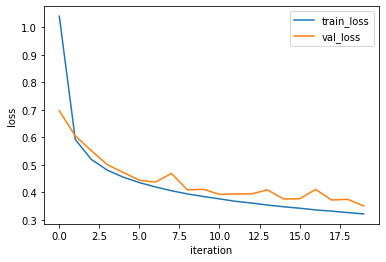

0.882


In [29]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

print(cn.score(x_val, y_val_encoded))